# Heart Disease Data Preparation

This notebook performs data cleansing, feature engineering, and exploration for the Heart Disease dataset.
It includes MLflow logging and prepares data for potential downstream modeling tasks.

I have downloaded the dataset from [Kaggle-Heart Failure Prediction](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction)


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import mlflow.sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Load the heart disease dataset
df = pd.read_csv('../data/heart.csv')
df.head(10)

Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   
5   39   M           NAP        120          339          0     Normal    170   
6   45   F           ATA        130          237          0     Normal    170   
7   54   M           ATA        110          208          0     Normal    142   
8   37   M           ASY        140          207          0     Normal    130   
9   48   F           ATA        120          284          0     Normal    120   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0  
5              N      0.0       Up             0  
6              N      0.0       Up             0  
7              N      0.0       Up             0  
8              Y      1.5     Flat             1  
9              N      0.0       Up             0

## Data Cleansing
We drop rows with empty values and remove duplicates.

In [3]:
# This dataset is already clean and deduplicated but I will do to show the process of data cleansing

# Load the heart disease dataset
df = pd.read_csv('../data/heart.csv')
df.head(10)

# Drop rows with any missing values (precautionary)
df_clean = df.dropna()
print(f"Rows after dropna: {df_clean.shape[0]} (removed {df.shape[0] - df_clean.shape[0]} rows)")

# Remove duplicates
df_clean = df_clean.drop_duplicates()
print(f"Rows after deduplication: {df_clean.shape[0]}")

Rows after dropna: 918 (removed 0 rows)
Rows after deduplication: 918


## Data Exploration
Explore the cleaned dataset.

## One‚ÄëHot Encoding of Categorical Features
We convert non‚Äënumeric categorical variables into binary or one-hot-encoded dummy columns so they can be included in our correlation analysis and subsequent modeling steps.

In [4]:
# show all values of the column 'ChestPainType'
print(set(df_clean['ChestPainType'].values))

# show all values of the column 'RestingECG'
print(set(df_clean['RestingECG'].values))

# show all values of the column 'ST_Slope'
print(set(df_clean['ST_Slope'].values))

# show all values of the column 'Sex'
print(set(df_clean['Sex'].values))

# show all values of the column 'ExerciseAngina'
print(set(df_clean['ExerciseAngina'].values))

{'NAP', 'TA', 'ATA', 'ASY'}
{'ST', 'Normal', 'LVH'}
{'Down', 'Up', 'Flat'}
{'F', 'M'}
{'Y', 'N'}


In [5]:
# Convert categorical columns to binary values
df_clean['Sex'] = df_clean['Sex'].map({'M': 1, 'F': 0})
df_clean['ExerciseAngina'] = df_clean['ExerciseAngina'].map({'Y': 1, 'N': 0})


# One-hot encode categorical features
cat_cols = ['ChestPainType', 'RestingECG', 'ST_Slope']
df_enc = pd.get_dummies(df_clean, columns=cat_cols, drop_first=True)
print(f'Shape after encoding: {df_enc.shape}')

# Preview the first few rows
df_enc.head(10)

Shape after encoding: (918, 16)


Age  Sex  RestingBP  Cholesterol  FastingBS  MaxHR  ExerciseAngina  \
0   40    1        140          289          0    172               0   
1   49    0        160          180          0    156               0   
2   37    1        130          283          0     98               0   
3   48    0        138          214          0    108               1   
4   54    1        150          195          0    122               0   
5   39    1        120          339          0    170               0   
6   45    0        130          237          0    170               0   
7   54    1        110          208          0    142               0   
8   37    1        140          207          0    130               1   
9   48    0        120          284          0    120               0   

   Oldpeak  HeartDisease  ChestPainType_ATA  ChestPainType_NAP  \
0      0.0             0               True              False   
1      1.0             1              False               True   
2      0.0             0               True              False   
3      1.5             1              False              False   
4      0.0             0              False               True   
5      0.0             0              False               True   
6      0.0             0               True              False   
7      0.0             0               True              False   
8      1.5             1              False              False   
9      0.0             0               True              False   

   ChestPainType_TA  RestingECG_Normal  RestingECG_ST  ST_Slope_Flat  \
0             False               True          False          False   
1             False               True          False           True   
2             False              False           True          False   
3             False               True          False           True   
4             False               True          False          False   
5             False               True          False          False   
6             False               True          False          False   
7             False               True          False          False   
8             False               True          False           True   
9             False               True          False          False   

   ST_Slope_Up  
0         True  
1        False  
2         True  
3        False  
4         True  
5         True  
6         True  
7         True  
8        False  
9         True

In [6]:
# Basic statistics
df_clean.describe()

Age         Sex   RestingBP  Cholesterol   FastingBS  \
count  918.000000  918.000000  918.000000   918.000000  918.000000   
mean    53.510893    0.789760  132.396514   198.799564    0.233115   
std      9.432617    0.407701   18.514154   109.384145    0.423046   
min     28.000000    0.000000    0.000000     0.000000    0.000000   
25%     47.000000    1.000000  120.000000   173.250000    0.000000   
50%     54.000000    1.000000  130.000000   223.000000    0.000000   
75%     60.000000    1.000000  140.000000   267.000000    0.000000   
max     77.000000    1.000000  200.000000   603.000000    1.000000   

            MaxHR  ExerciseAngina     Oldpeak  HeartDisease  
count  918.000000      918.000000  918.000000    918.000000  
mean   136.809368        0.404139    0.887364      0.553377  
std     25.460334        0.490992    1.066570      0.497414  
min     60.000000        0.000000   -2.600000      0.000000  
25%    120.000000        0.000000    0.000000      0.000000  
50%    138.000000        0.000000    0.600000      1.000000  
75%    156.000000        1.000000    1.500000      1.000000  
max    202.000000        1.000000    6.200000      1.000000

## Correlation Heat‚Äëmap (All Features)
This heat‚Äëmap shows correlations for **all** features, including the newly created one-hot (dummy) columns.

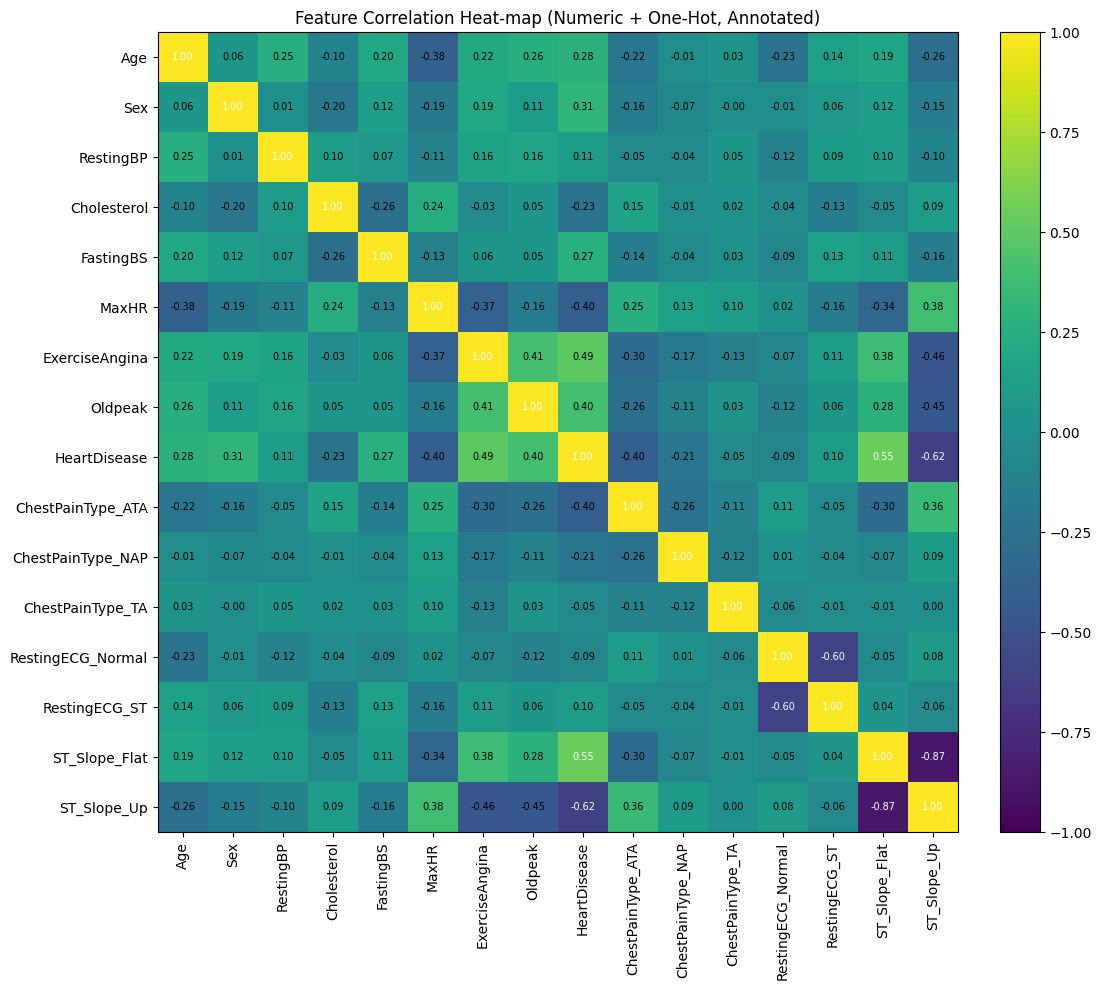

In [7]:
import numpy as np
import matplotlib.pyplot as plt

corr = df_enc.corr()

fig, ax = plt.subplots(figsize=(12, 10))
im = ax.imshow(corr, vmin=-1, vmax=1, cmap='viridis')

# Axis ticks & labels
ax.set_xticks(range(len(corr.columns)))
ax.set_yticks(range(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=90)
ax.set_yticklabels(corr.columns)

# Annotate each cell with the correlation coefficient
for (i, j), z in np.ndenumerate(corr.values):
    text_color = 'white' if abs(z) > 0.5 else 'black'
    ax.text(j, i, f'{z:.2f}', ha='center', va='center', fontsize=7, color=text_color)

# Color‚Äëbar & layout
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
ax.set_title('Feature Correlation Heat‚Äëmap (Numeric + One‚ÄëHot, Annotated)')
plt.tight_layout()
plt.show()

# Log to MLflow
import mlflow
with mlflow.start_run(nested=True):
    mlflow.log_figure(fig, 'eda/corr_full_annotated.png')

**Quick take-aways from the full, annotated correlation map**

| Observation                                  | What it tells us                                                                                                                                                                                                                                                                                                                         |            |                                                                                                                                                                                                                                                                                                                                                       |
| -------------------------------------------- | ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | ---------- | ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| \*\*Strongest predictors of `HeartDisease` ( | r                                                                                                                                                                                                                                                                                                                                        | ‚â• 0.4)\*\* | ‚Ä¢ `Oldpeak` (+0.49) ‚Äì more ST-depression during exercise ‚Üí higher risk.<br>‚Ä¢ `ExerciseAngina` (+0.49) ‚Äì angina induced by exercise strongly linked to disease.<br>‚Ä¢ `ST_Slope_Flat` (+0.55) vs. `ST_Slope_Up` (-0.62) ‚Äì flat slope is common in patients, up-sloping is protective.<br>‚Ä¢ `MaxHR` (-0.40) ‚Äì higher attainable heart-rate ‚Üí lower risk. |
| **Secondary signals**                        | ‚Ä¢ `Age` (+0.28) and `FastingBS` (+0.27) show moderate positive links.<br>‚Ä¢ `Cholesterol` (-0.23) and `RestingBP` (+0.11) have only weak linear association with the target.                                                                                                                                                              |            |                                                                                                                                                                                                                                                                                                                                                       |
| **Feature inter-relationships**              | ‚Ä¢ `ST_Slope_Flat` vs. `ST_Slope_Up`: r = -0.87 ‚Äì expected, they are mutually exclusive dummy variables.<br>‚Ä¢ `RestingECG_Normal` vs. `RestingECG_ST`: r = -0.60 ‚Äì same dummy-coding effect.<br>‚Ä¢ `ExerciseAngina` correlates with `Oldpeak` (+0.41) and `ST_Slope_Flat` (+0.55), consistent with the treadmill-test physiology.          |            |                                                                                                                                                                                                                                                                                                                                                       |
| **Multicollinearity concerns**               | The strong negative pairs above arise from one-hot encoding and are harmless for tree models, but could inflate variance in linear/logistic regression‚Äîconsider dropping one of each mutually exclusive set or using regularisation.                                                                                                     |            |                                                                                                                                                                                                                                                                                                                                                       |
| **Actionable insights for modelling**        | 1. Keep **Oldpeak, ExerciseAngina, ST\_Slope dummies, MaxHR** as key features.<br>2. Consider interaction terms (e.g., Age √ó MaxHR) because Age alone is only weakly correlated but non-linear effects are plausible.<br>3. Continuous variables with weak r still matter for non-linear models; don‚Äôt discard them solely on Pearson r. |            |                                                                                                                                                                                                                                                                                                                                                       |

*In short:* treadmill-test findings (ST-slope pattern, exercise-induced angina, maximum heart-rate achieved) dominate the linear signal, while classic resting measurements (cholesterol, resting BP) add little linear information on their own.


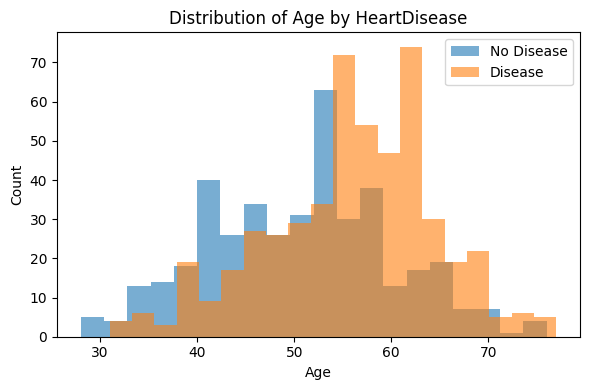

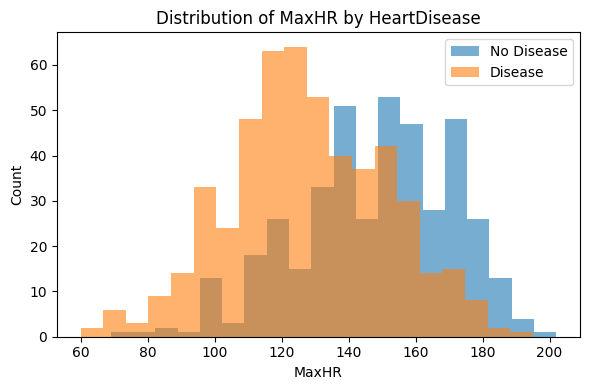

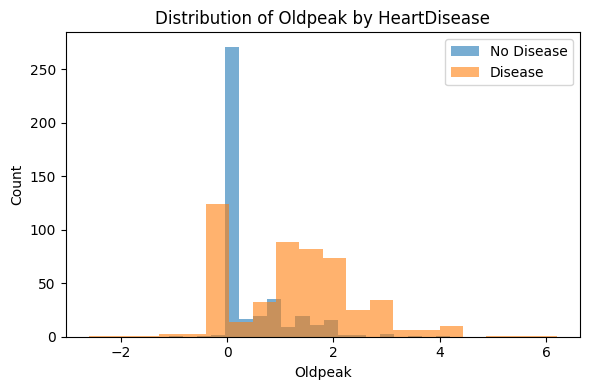

<Figure size 640x480 with 0 Axes>

In [8]:
# ===== Overlayed histograms for numeric features by HeartDisease =====
import matplotlib.pyplot as plt

def hist_by_target(feature, bins=20):
    """
    Draw two overlapping histograms of `feature`,
    split by HeartDisease (0 = no disease, 1 = disease).
    """
    plt.figure(figsize=(6, 4))
    plt.hist(df_clean[df_clean['HeartDisease'] == 0][feature],
             bins=bins, alpha=0.6, label='No Disease')
    plt.hist(df_clean[df_clean['HeartDisease'] == 1][feature],
             bins=bins, alpha=0.6, label='Disease')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.title(f'Distribution of {feature} by HeartDisease')
    plt.legend()
    plt.tight_layout()
    plt.show()

# --- pick the features you want to inspect ---
for feat in ['Age', 'MaxHR', 'Oldpeak']:
    hist_by_target(feat)

# Optional: log the last plot to MLflow
import mlflow
with mlflow.start_run(nested=True):
    mlflow.log_figure(plt.gcf(), f'eda/hist_{feat}.png')


### Interpretation of the three over-laid histograms (English)

| Feature                                              | Visual pattern                                                                                                                                                                                        | Take-away                                                                                                                                                                                |
| ---------------------------------------------------- | ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Age**                                              | The orange curve (patients **with** HeartDisease) is shifted to the right‚Äîespecially in the **55‚Äì70 yr** range. The blue curve (no disease) dominates below **‚âà50 yr**. There is still heavy overlap. | Age alone is **not a sharp discriminator**, but the trend is clear: risk increases with age. Useful actions: create age bins or spline features to capture the non-linear effect.        |
| **MaxHR** (maximum heart rate on the treadmill test) | Healthy patients (blue) cluster more often above **150 bpm**; diseased patients (orange) concentrate in the **90‚Äì140 bpm** band.                                                                      | High MaxHR appears *protective* (negatively associated with the target). Consider a threshold feature such as `MaxHR > 150` or quantile-based bins.                                      |
| **Oldpeak** (ST-depression)                          | The blue distribution spikes at **0 mm** (no ST-depression). The orange distribution spreads broadly between **1 and 4 mm**.                                                                          | Oldpeak is a **strong positive predictor**: any depression above \~0.5 mm tilts the odds toward disease. You might add a binary flag `Oldpeak>0` or stepped bins (0, 0.1‚Äì1, 1‚Äì2, >2 mm). |

---

#### Actionable feature-engineering ideas

1. **Age**

   ```python
   df_clean['AgeGroup'] = pd.cut(df_clean['Age'],
                                 bins=[0, 45, 55, 65, 120],
                                 labels=['<45', '45-55', '55-65', '65+'])
   ```

2. **MaxHR**
   *Option A:* standardise; *Option B:*

   ```python
   df_clean['HighMaxHR'] = (df_clean['MaxHR'] > 150).astype(int)
   ```

3. **Oldpeak**
   *Option A:* `df_clean['LogOldpeak'] = np.log1p(df_clean['Oldpeak'])`
   *Option B:* discrete bins as noted above.

4. **Interactions**
   Combine features, e.g. `Age √ó MaxHR` or `Oldpeak √ó ST_Slope_Flat`, to capture compound effects.

**Summary:**
The plots reinforce the earlier correlation findings: **Oldpeak** and **MaxHR** have the clearest class-separation, while **Age** contributes a weaker but consistent gradient that benefits from non-linear treatment.


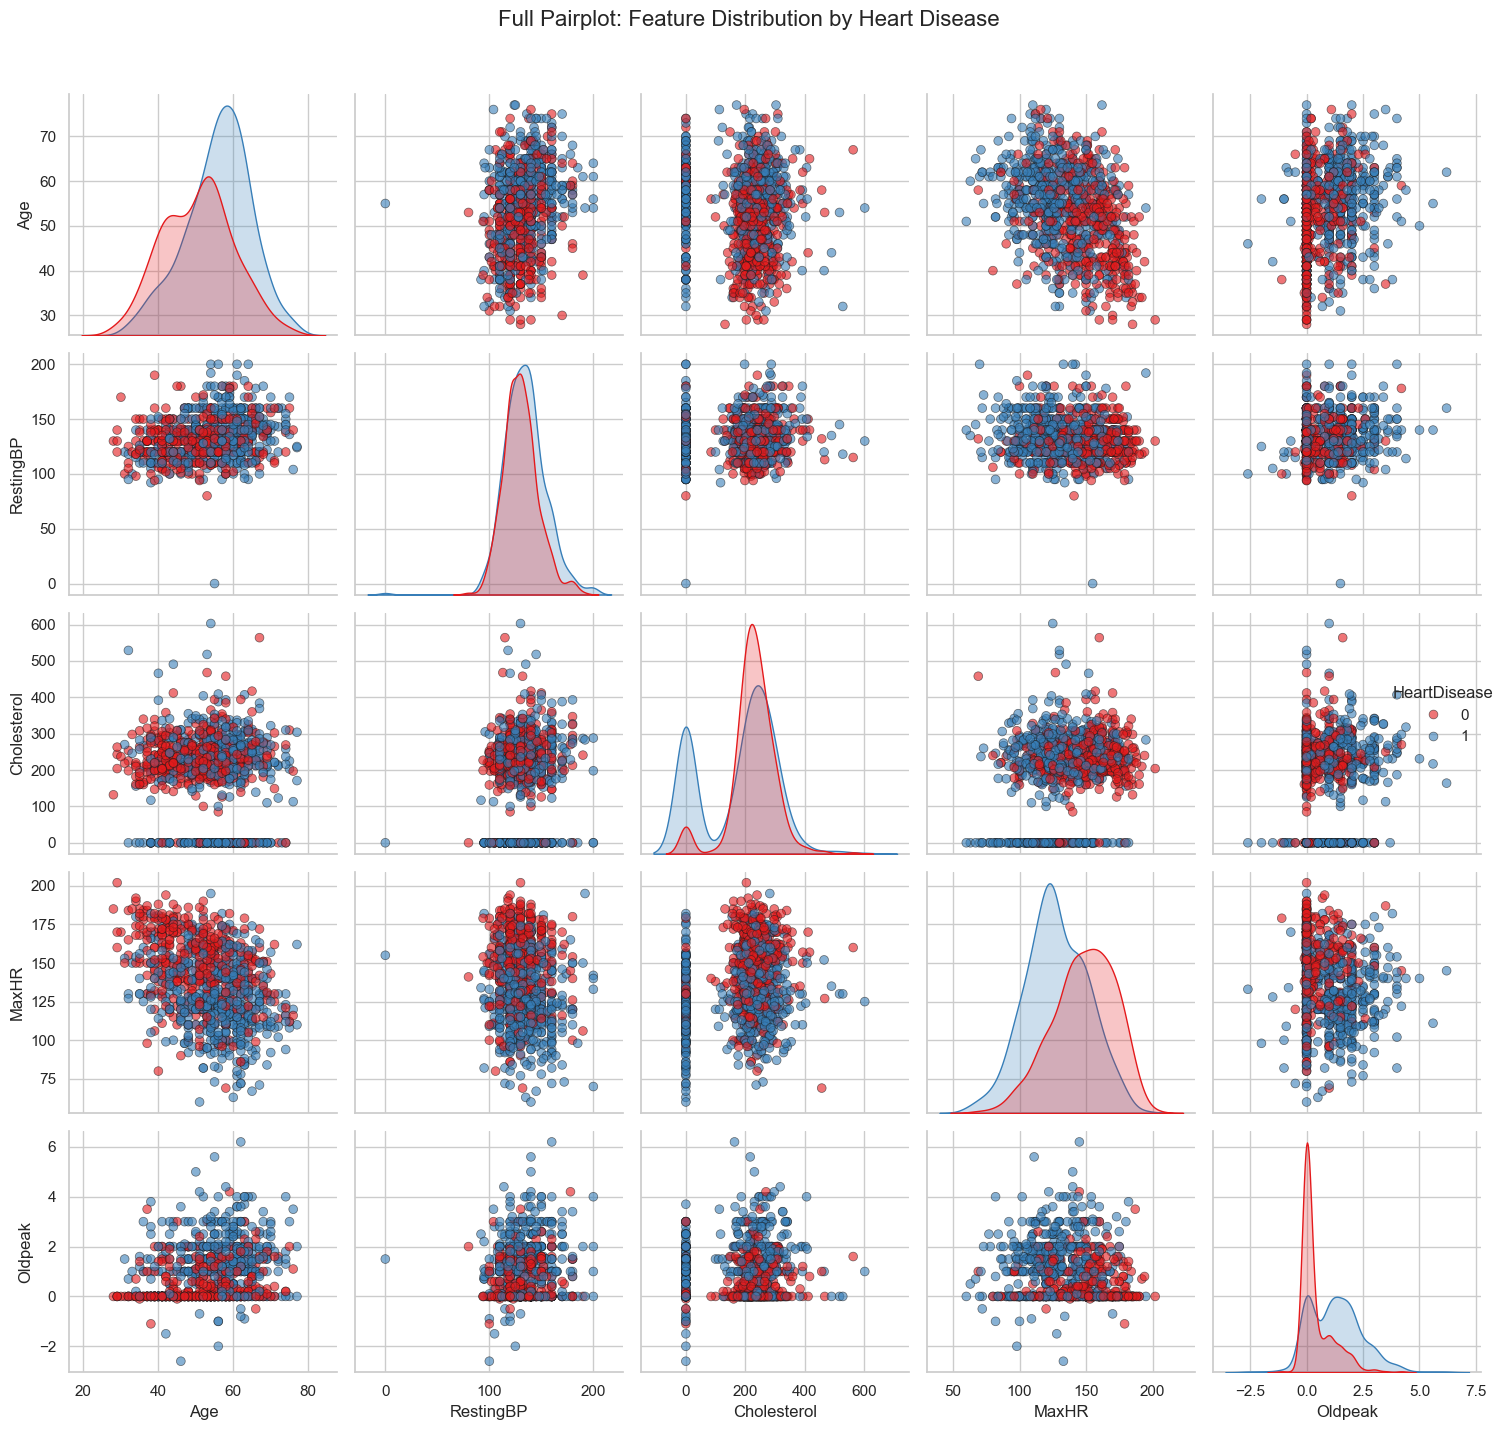

In [19]:
# I have taken this pairplot from: https://www.kaggle.com/code/rajbirahmed/heart-failure-prediction

sns.set(style="whitegrid", context="notebook")
features = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak', 'HeartDisease']
pair = sns.pairplot(
    df[features], hue='HeartDisease', palette='Set1', diag_kind='kde', plot_kws={'alpha': 0.6, 's': 40, 'edgecolor': 'k'}, height=2.8
)

pair.fig.suptitle("Full Pairplot: Feature Distribution by Heart Disease", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

### How to read a Seaborn **pairplot**

1. **Layout**

   * Each cell combines two features: the column-variable on the *x-axis* and the row-variable on the *y-axis*.
   * **Diagonal cells** show the univariate distribution of a single feature (here: kernel-density curves split by colour).
   * **Off-diagonal cells** are scatterplots of every pairwise combination.

2. **Colour (hue)**

   * Blue =`HeartDisease 0` (no disease)
   * Red =`HeartDisease 1` (disease)
     Patterns where colours separate well ‚Üí potentially predictive.

---

### What we see in *this* pairplot

| Cell(s)                                | Visual clue                                                                                                                       | Interpretation                                                                |
| -------------------------------------- | --------------------------------------------------------------------------------------------------------------------------------- | ----------------------------------------------------------------------------- |
| **Diagonal ‚Äì Age**                     | Red KDE curve peaks around **58‚Äì60 yr**, blue around **50 yr**                                                                    | Older patients are more likely to have the disease.                           |
| **Diagonal ‚Äì MaxHR**                   | Blue density leans right (‚âà150‚Äì180 bpm), red left (‚âà100‚Äì140 bpm)                                                                  | Higher achievable heart-rate is protective.                                   |
| **Diagonal ‚Äì Oldpeak**                 | Red curve clearly shifted right (1‚Äì3 mm); blue spikes at 0 mm                                                                     | ST-depression is common in diseased patients, rare in healthy ones.           |
| **Age √ó MaxHR**                        | Downward slope *and* colour separation: red points cluster top-left (older & low MaxHR), blue bottom-right (younger & high MaxHR) | Confirms the combined risk of age and low MaxHR; a possible interaction term. |
| **Age √ó Oldpeak**                      | Mild upward trend; many red points at high Oldpeak                                                                                | Older patients often show larger ST-depression ‚Üí compounding risk.            |
| **MaxHR √ó Oldpeak**                    | Slight negative slope; region of **high Oldpeak & low MaxHR** is almost entirely red                                              | Suggests a ‚Äúdouble-whammy‚Äù zone that almost guarantees disease.               |
| **RestingBP & Cholesterol vs. others** | Clouds are mixed (blue and red heavily overlap)                                                                                   | Little linear separation; these variables alone carry weak signal.            |

---

### Practical take-aways

1. **Feature interactions:**
   *Create cross-features* like `Age √ó MaxHR` or a boolean flag `Oldpeak>1 & MaxHR<120`.
2. **Non-linear modelling:**
   Visible curvatures & overlaps indicate tree/boosting models (or splines) will capture patterns better than pure linear terms.
3. **Outlier check:**
   No extreme outliers dominate; data spread looks reasonably compact.
4. **Redundant features:**
   `RestingBP` and `Cholesterol` add little separation visually; they may still help a tree model but could be dropped for a simpler linear baseline.


## Feature Engineering
Create and transform features.

## Run Experiments - Log inte MLFlow


In [21]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, roc_curve
import mlflow
import numpy as np
import pandas as pd

In [35]:
def run_experiment(X, y, experiment_name, n_estimators=50, max_depth=None):
    """
    Utility: train/test split, RF training, metric dict return & MLflow logging.
    """
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Scale numeric features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)


    with mlflow.start_run(run_name=experiment_name):
        # Train the model
        clf = RandomForestClassifier(
            n_estimators=n_estimators, max_depth=max_depth, random_state=42
        )
        clf.fit(X_train_scaled, y_train)

        y_pred = clf.predict(X_test_scaled)
        y_prob = clf.predict_proba(X_test)[:, 1]

        metrics = {
            "accuracy": accuracy_score(y_test, y_pred),
            "f1": f1_score(y_test, y_pred),
            "roc_auc": roc_auc_score(y_test, y_prob)         
        }

        # log metrics + model
        mlflow.log_metrics(metrics)
        mlflow.sklearn.log_model(clf, artifact_path="model")

        # optional: print report
        print(f"=== {experiment_name} ===")
        print(classification_report(y_test, y_pred))
        print({k: f"{v:.3f}" for k, v in metrics.items()}, "\n")
    
    return metrics, confusion_matrix(y_test, y_pred)

2025/08/03 18:00:07 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/03 18:00:11 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/08/03 18:00:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


=== Baseline_RF ===
              precision    recall  f1-score   support

           0       0.87      0.84      0.86        82
           1       0.88      0.90      0.89       102

    accuracy                           0.88       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.87      0.88      0.87       184

{'accuracy': '0.875', 'f1': '0.889', 'roc_auc': '0.841'} 



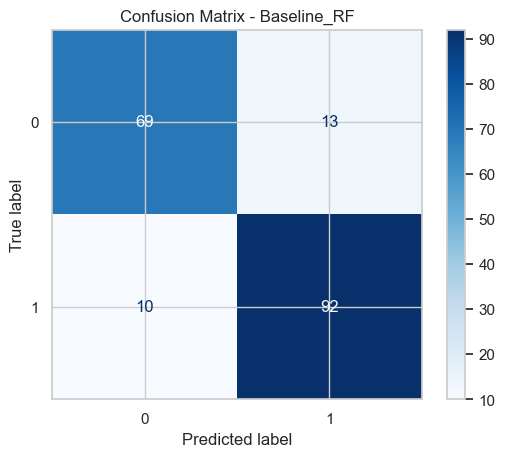

In [36]:
# ================================================================
# Baseline: train & evaluate without extra feature engineering
# ================================================================

# ---- baseline feature matrix (df_enc kommt aus vorherigen Steps) ----
X_base = df_enc.drop(columns=["HeartDisease"])
y = df_enc["HeartDisease"]

metrics_base, conf_matrix_base = run_experiment(X_base, y, experiment_name="Baseline_RF")

# ---- confusion matrix ----
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_base)
disp.plot(cmap="Blues")
plt.title(f"Confusion Matrix - Baseline_RF")
plt.show()



## Feature Engineering

2025/08/03 18:00:26 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/03 18:00:30 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/08/03 18:00:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


=== FeatureEng_RF ===
              precision    recall  f1-score   support

           0       0.87      0.87      0.87        82
           1       0.89      0.89      0.89       102

    accuracy                           0.88       184
   macro avg       0.88      0.88      0.88       184
weighted avg       0.88      0.88      0.88       184

{'accuracy': '0.880', 'f1': '0.892', 'roc_auc': '0.839'} 



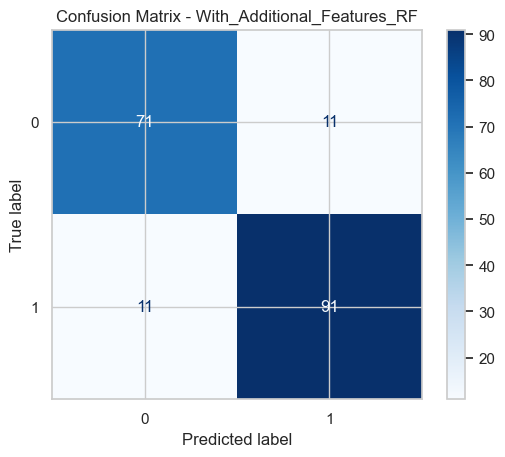

In [37]:
# ================================================================
# Feature-Engineering-Block
# ================================================================

df_fe = df_enc.copy()

# Age bins
df_fe["AgeGroup"] = pd.cut(
    df_fe["Age"],
    bins=[0, 45, 55, 65, 120],
    labels=["<45", "45-55", "55-65", "65+"]
)

# Binary flag: high maximum HR
df_fe["HighMaxHR"] = (df_fe["MaxHR"] > 150).astype(int)


# Interaktion: ExerciseAngina * Oldpeak  (captures additive risk)
df_fe["Angina_Oldpeak"] = df_fe["ExerciseAngina"] * df_fe["Oldpeak"]

# One-hot encode the newly created AgeGroup (drop_first avoids multicollinearity)
df_fe = pd.get_dummies(df_fe, columns=["AgeGroup"], drop_first=True)

# ---- engineered feature matrix ----
X_fe = df_fe.drop(columns=["HeartDisease"])
y = df_fe["HeartDisease"]

metrics_fe, conf_matrix_fe = run_experiment(X_fe, y, experiment_name="FeatureEng_RF")

# ---- confusion matrix ----
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_fe)
disp.plot(cmap="Blues")
plt.title(f"Confusion Matrix - With_Additional_Features_RF")
plt.show()


In [38]:
# ================================================================
# 3Ô∏è‚É£  Simple comparison printout
# ================================================================
print("üîé  Metric comparison (Baseline  ‚ûú  Feature Engineering)")
for m in metrics_base.keys():
    base_val = metrics_base[m]
    fe_val   = metrics_fe[m]
    delta    = fe_val - base_val
    print(f"{m:<9}: {base_val:.3f}  ‚ûú  {fe_val:.3f}   (Œî {delta:+.3f})")

üîé  Metric comparison (Baseline  ‚ûú  Feature Engineering)
accuracy : 0.875  ‚ûú  0.880   (Œî +0.005)
f1       : 0.889  ‚ûú  0.892   (Œî +0.003)
roc_auc  : 0.841  ‚ûú  0.839   (Œî -0.002)
